## About Kernel:

This kernel is all about how one can perform Sentiment Analysis on twitter dataset using Logistic Regression model from scratch. Given a tweet, we will decide if it has a positive sentiment or a negative one. 

## About the Twitter dataset

The sample dataset from NLTK is separated into positive and negative tweets. It contains 5000 positive tweets and 5000 negative tweets exactly. The exact match between these classes is not a coincidence. The intention is to have a balanced dataset.


In [91]:
import warnings

import matplotlib.pyplot as plt  # visualization library
import nltk  # Python library for NLP

warnings.filterwarnings("ignore")

In [92]:
# downloads sample twitter dataset.
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\Plamen\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [93]:
import numpy as np
from nltk.corpus import twitter_samples 

# download the stopwords for the process_tweet function
nltk.download('stopwords')

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Plamen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
twitter_samples.fileids()

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']

## Prepare the data
* The `twitter_samples` contains subsets of 5,000 positive tweets, 5,000 negative tweets, and the full set of 10,000 tweets.  
    

In [95]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# concatenate the lists, 1st part is the positive tweets followed by the negative
tweets = all_positive_tweets + all_negative_tweets

In [96]:
# make a numpy array representing labels of the tweets
labels = np.append(np.ones((len(all_positive_tweets))), np.zeros((len(all_negative_tweets))))

* Train test split: 20% will be in the test set, and 80% in the training set.


In [97]:
# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

* Create the numpy array of positive labels and negative labels.

In [98]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [99]:
# Print the shape train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


# Preprocess raw text for Sentiment analysis

Data preprocessing is one of the critical steps in any machine learning project. It includes cleaning and formatting the data before feeding into a machine learning algorithm. For NLP, the preprocessing steps are comprised of the following tasks:

1. **Tokenizing the string:** To tokenize means to split the strings into individual words without blanks or tabs.

2. **Lowercasing:** In this step, we will also convert each word in the string to lower case.

3. **Removing stop words and punctuation:**

Since we have a Twitter dataset, we'd like to remove some substrings commonly used on the platform like the hashtag, retweet marks, and hyperlinks. We'll use the re library to perform regular expression operations on our tweet. We'll define our search pattern and use the sub() method to remove matches by substituting with an empty character (i.e. '').

4. **Stemming:** Stemming is the process of converting a word to its most general form, or stem. This helps in reducing the size of our vocabulary.

Consider the words: 
 * **learn**
 * **learn**ing
 * **learn**ed
 * **learn**t
 
All these words are stemmed from its common root **learn**. However, in some cases, the stemming process produces words that are not correct spellings of the root word. For example, **happi** and **sunni**. That's because it chooses the most common stem for related words. For example, we can look at the set of words that comprises the different forms of happy:

 * **happ**y
 * **happi**ness
 * **happi**er
 
We can see that the prefix **happi** is more commonly used. We cannot choose **happ** because it is the stem of unrelated words like **happen**.
 
NLTK has different modules for stemming but in this kernel i will be using the PorterStemmer.

In [100]:
def process_tweet(tweet):
   
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    
#     # remove stock market tickers like $GE
#     tweet = re.sub(r'\$\w*', '', tweet)
    
#     # remove old style retweet text "RT"
#     tweet = re.sub(r'^RT[\s]+', '', tweet)
    
#     # remove hyperlinks
#     tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
#     # remove hashtags
#     # only removing the hash # sign from the word
#     tweet = re.sub(r'#', '', tweet)
    
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = tweet_tokens
#     tweets_clean = []
#     for word in tweet_tokens:
#         if (word not in stopwords_english): # and  # remove stopwords
# #                 word not in string.punctuation):  # remove punctuation
#             # tweets_clean.append(word)
#             stem_word = stemmer.stem(word)  # stemming word
#             tweets_clean.append(stem_word)

    return tweets_clean


In [101]:
def build_freqs(tweets, ys):
    
    # tweets: a list of tweets
    # ys: an m x 1 array with the sentiment label of each tweet (either 0 or 1)
   
    yslist = np.squeeze(ys).tolist()

    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    
    # freqs: a dictionary mapping each (word, sentiment) pair to its frequency
    
    return freqs                   

## Table of word counts

In [102]:
# create frequency dictionary
freqs = build_freqs(tweets, labels)

# check data type
print(f'type(freqs) = {type(freqs)}')

# check length of the dictionary
print(f'len(freqs) = {len(freqs)}')

type(freqs) = <class 'dict'>
len(freqs) = 17664


We will select a set of words that we would like to visualize.

In [103]:
# select some words to appear in the report. we will assume that each word is unique (i.e. no duplicates)
keys = ['happi', 'merri', 'nice', 'good', 'bad', 'sad', 'mad', 'best', 'pretti',
        '❤', ':)', ':(', '😒', '😬', '😄', '😍', '♛',
        'song', 'idea', 'power', 'play', 'magnific']

# each element consist of a sublist with this pattern: [<word>, <positive_count>, <negative_count>]
data = []

# loop through our selected words
for word in keys:
    
    # initialize positive and negative counts
    pos = 0
    neg = 0
    
    # retrieve number of positive counts
    if (word, 1) in freqs:
        pos = freqs[(word, 1)]
        
    # retrieve number of negative counts
    if (word, 0) in freqs:
        neg = freqs[(word, 0)]
        
    # append the word counts to the table
    data.append([word, pos, neg])
    
data

[['happi', 0, 0],
 ['merri', 0, 0],
 ['nice', 99, 18],
 ['good', 234, 99],
 ['bad', 18, 68],
 ['sad', 4, 121],
 ['mad', 2, 9],
 ['best', 64, 22],
 ['pretti', 0, 0],
 ['❤', 29, 21],
 [':)', 3691, 2],
 [':(', 1, 4585],
 ['😒', 2, 3],
 ['😬', 0, 2],
 ['😄', 5, 1],
 ['😍', 5, 1],
 ['♛', 0, 210],
 ['song', 15, 22],
 ['idea', 21, 10],
 ['power', 4, 5],
 ['play', 18, 27],
 ['magnific', 0, 0]]

We can then use a scatter plot to inspect this table visually. Instead of plotting the raw counts, we will plot it in the logarithmic scale to take into account the wide discrepancies between the raw counts (e.g. `:)` has 3568 counts in the positive while only 2 in the negative). The red line marks the boundary between positive and negative areas. Words close to the red line can be classified as neutral. 

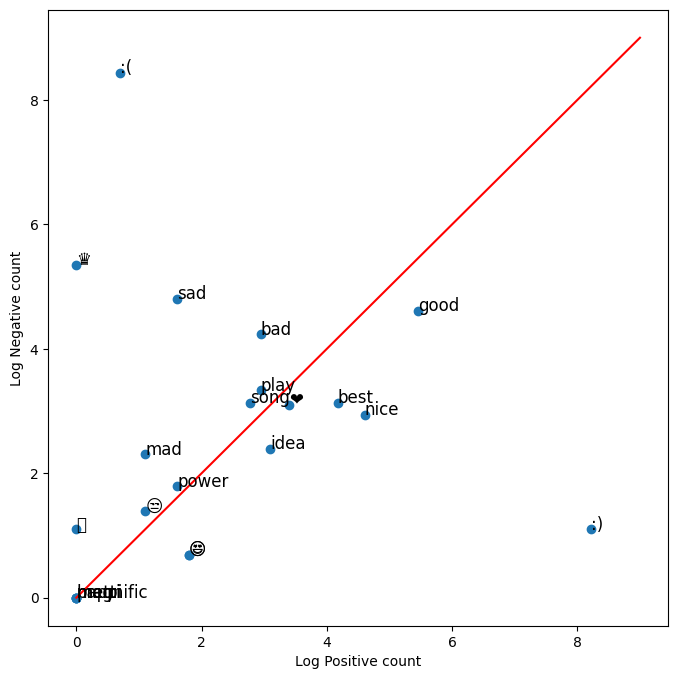

In [104]:
fig, ax = plt.subplots(figsize = (8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])  

# do the same for the negative counts
y = np.log([x[2] + 1 for x in data]) 

# Plot a dot for each pair of words
ax.scatter(x, y)  

# assign axis labels
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red')  # Plot the red line that divides the 2 areas.
plt.show()

# Visualizing tweets and the Logistic Regression model


In [105]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))

type(freqs) = <class 'dict'>
len(freqs) = 15140


### Process tweet
The given function `process_tweet()` tokenizes the tweet into individual words, removes stop words and applies stemming.

In [106]:
# test the function below
print('This is an example of a positive tweet: \n', train_x[0])
print('\nThis is an example of the processed version of the tweet: \n', process_tweet(train_x[0]))

This is an example of a positive tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)

This is an example of the processed version of the tweet: 
 ['#followfriday', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']


# Part 1: Logistic regression 

### Logistic regression
$$ h(z) = \frac{1}{1+\exp^{-z}}$$
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$

### Cost function and Gradient

The cost function used for logistic regression is the average of the log loss across all training examples:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)}))\tag{5} $$
* $m$ is the number of training examples
* $y^{(i)}$ is the actual label of the i-th training example.
* $h(z(\theta)^{(i)})$ is the model's prediction for the i-th training example.

The loss function for a single training example is
$$ Loss = -1 \times \left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$$


* Note that when the model predicts 1 ($h(z(\theta)) = 1$) and the label $y$ is also 1, the loss for that training example is 0. 
* Similarly, when the model predicts 0 ($h(z(\theta)) = 0$) and the actual label is also 0, the loss for that training example is 0. 

### Update the weights

To update your weight vector $\theta$, you will apply gradient descent to iteratively improve your model's predictions.  
The gradient of the cost function $J$ with respect to one of the weights $\theta_j$ is:

$$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x_j \tag{5}$$
* 'i' is the index across all 'm' training examples.
* 'j' is the index of the weight $\theta_j$, so $x_j$ is the feature associated with weight $\theta_j$

* To update the weight $\theta_j$, we adjust it by subtracting a fraction of the gradient determined by $\alpha$:
$$\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $$
* The learning rate $\alpha$ is a value that we choose to control how big a single update will be.


In [107]:
def sigmoid(z): 

    h = 1/(1+np.exp(-z))
   
    return h

In [108]:
def gradientDescent(x, y, theta, alpha, num_iters):
   
    m = x.shape[0]
    
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x,theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = -(np.dot(y.T,np.log(h))+np.dot((1-y).T,np.log(1-h)))/m

        # update the weights theta
        theta = theta - alpha*(np.dot(x.T,h-y))/m
        
    J = float(J)
    return J, theta

# Part 2: Extracting the features

* Given a list of tweets, extract the features and store them in a matrix. You will extract two features.
    * The first feature is the number of positive words in a tweet.
    * The second feature is the number of negative words in a tweet. 
* Then train your logistic regression classifier on these features.
* Test the classifier on a validation set. 


In [109]:
def extract_features(tweet, freqs):
    
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
       
    # loop through each word in the list of words
    for word in word_l:
         
        if (word,1.0) in freqs:
            # increment the word count for the positive label 1
            x[0,1] += freqs[(word,1.0)]
        if(word,0.0) in freqs:
            # increment the word count for the negative label 0
            x[0,2] += freqs[(word,0.0)]
        
    return x

# Part 3: Training Your Model

To train the model:
* Stack the features for all training examples into a matrix `X`. 
* Call `gradientDescent`, which we've implemented above.

In [110]:
len(train_x)

8000

In [111]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

print(X.shape)
print(Y.shape)

(8000, 3)
(8000, 1)


In [112]:
# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)

print(f"The cost after training is {J:.6f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

The cost after training is 0.204750.
The resulting vector of weights is [4e-08, 0.0005593, -0.00053541]


# Part 4: Visualizing tweets 

Text(0, 0.5, 'Negative')

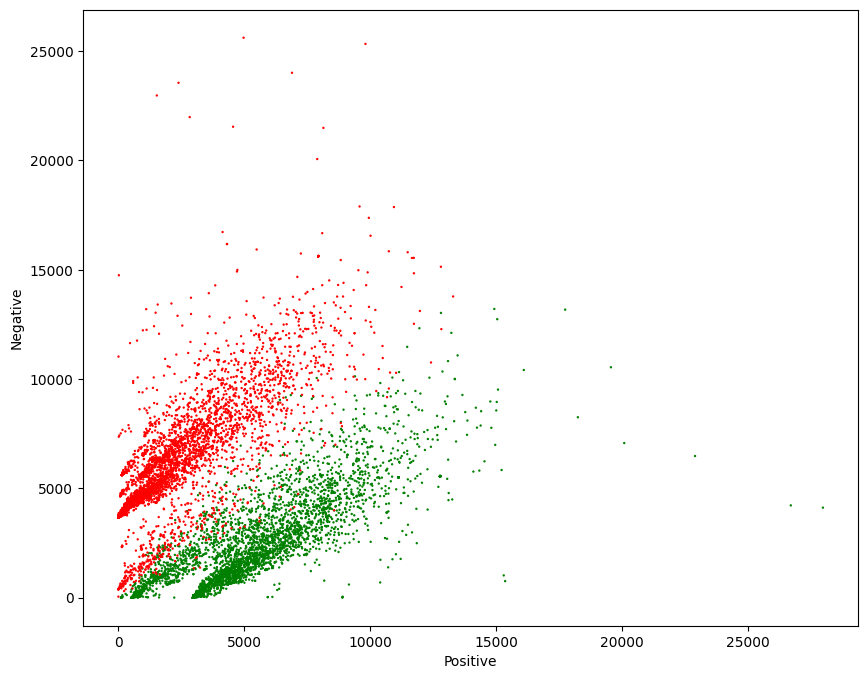

In [113]:
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (10, 8))

colors = ['red', 'green']

# Color based on the sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.5)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")

From the plot, it is evident that the features that we have chosen to represent tweets as numerical vectors allow an almost perfect separation between positive and negative tweets. So we can expect a very high accuracy for this model! 

## Plot the model alongside the data

We will draw a gray line to show the cutoff between the positive and negative regions. In other words, the gray line marks the line where $$ z = \theta * x = 0.$$
To draw this line, we have to solve the above equation in terms of one of the independent variables.

$$ z = \theta * x = 0$$
$$ x = [1, pos, neg] $$
$$ z(\theta, x) = \theta_0+ \theta_1 * pos + \theta_2 * neg = 0 $$
$$ neg = (-\theta_0 - \theta_1 * pos) / \theta_2 $$

In [114]:
# Equation for the separation plane
def neg(theta, pos):
    return (-theta[0] - pos * theta[1]) / theta[2]

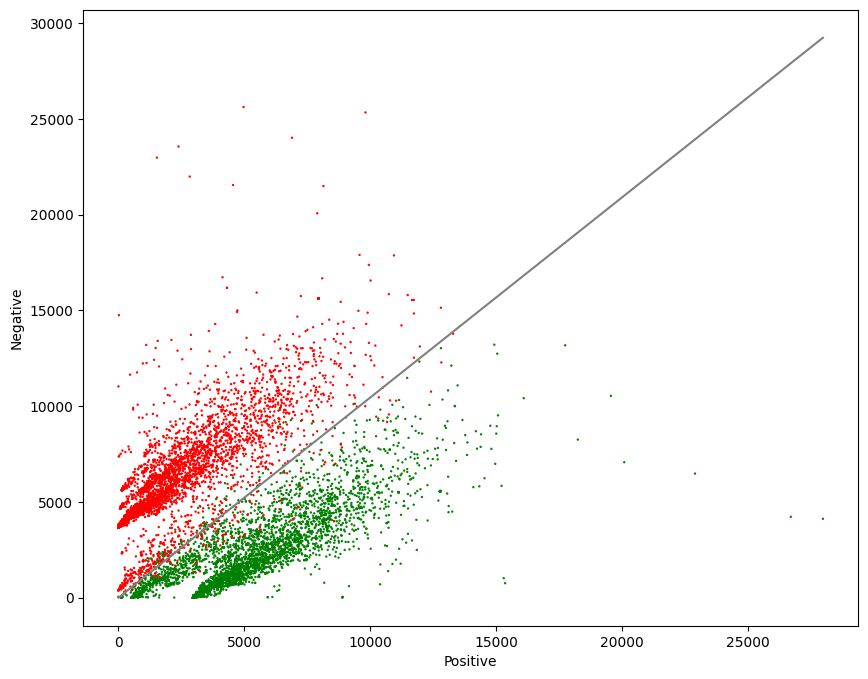

In [115]:
fig, ax = plt.subplots(figsize = (10, 8))

colors = ['red', 'green']

# Color base on the sentiment Y
ax.scatter(X[:,1], X[:,2], c=[colors[int(k)] for k in Y], s = 0.5)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")

# Now lets represent the logistic regression model in this chart. 
maxpos = np.max(X[:,1])           # max value in x-axis

# Plot a gray line that divides the 2 areas.
ax.plot([0,  maxpos], [neg(theta, 0),   neg(theta, maxpos)], color = 'gray') 

plt.show()

# Part 5: Test your logistic regression

In [116]:
def predict_tweet(tweet, freqs, theta):

    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x,theta))
    
    return y_pred

In [117]:
# check your own sentiment
my_tweet = 'I love machine learning :)'
y_pred_temp = predict_tweet(my_tweet, freqs, theta)
print(y_pred_temp)

if y_pred_temp > 0.5:
    print('Positive sentiment')
else: 
    print('Negative sentiment')

[[0.78012023]]
Positive sentiment


In [118]:
def test_logistic_regression(test_x, test_y, freqs, theta):
    """ 
    test_x: a list of tweets
    test_y: (m, 1) vector with the corresponding labels for the list of tweets
    """
    
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            y_hat.append(1.0)
        else:
            y_hat.append(0.0)

    accuracy = np.sum(np.squeeze(test_y) == np.squeeze(np.asarray(y_hat)))/len(test_y)

    return accuracy

In [119]:
test_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {test_accuracy:.4f}")

Logistic regression model's accuracy = 0.9680


# Part 6: Error Analysis

In this part you will see some tweets that your model misclassified. Why do you think the misclassifications happened? Specifically what kind of tweets does your model misclassify?

In [120]:
print('Label Predicted Tweet')
for x,y in zip(test_x,test_y):
    y_hat = predict_tweet(x, freqs, theta)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))

Label Predicted Tweet
THE TWEET IS: @FindBenNeedham it's my birthday today so for my birthday wish I hope there's good news about Ben soon :-)
THE PROCESSED TWEET IS: ["it's", 'my', 'birthday', 'today', 'so', 'for', 'my', 'birthday', 'wish', 'i', 'hope', "there's", 'good', 'news', 'about', 'ben', 'soon', ':-)']
1	0.46003327	b"it's my birthday today so for my birthday wish i hope there's good news about ben soon :-)"
THE TWEET IS: @SeniorSpazz @TehSmileys I was bored so I did EVERYTHING :D
THE PROCESSED TWEET IS: ['i', 'was', 'bored', 'so', 'i', 'did', 'everything', ':D']
1	0.31052593	b'i was bored so i did everything :D'
THE TWEET IS: @B_Madhura @shabnam_903 i should tweet it :p
THE PROCESSED TWEET IS: ['i', 'should', 'tweet', 'it', ':p']
1	0.40755874	b'i should tweet it :p'
THE TWEET IS: #AM to CA. Retweet domg nanti difollow ?( :D
THE PROCESSED TWEET IS: ['#am', 'to', 'ca', '.', 'retweet', 'domg', 'nanti', 'difollow', '?', '(', ':D']
1	0.48279685	b'#am to ca . retweet domg nanti difo

### If you really like this kernel then please do not forget to upvote it... 😊✌🏻